# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [0]:
#spring1819_assignment1
!wget --header="Host: cs231n.github.io" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://cs231n.github.io/assignments2019/assignment1/" --header="Cookie: _ga=GA1.3.1749333575.1552228690; c2VwLW5vLXJlZGlyZWN0; _gid=GA1.3.190213769.1563347532" --header="Connection: keep-alive" "http://cs231n.github.io/assignments/2019/spring1819_assignment1.zip" -O "spring1819_assignment1.zip" -c

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2019-07-23 06:45:52--  http://cs231n.github.io/assignments/2019/spring1819_assignment1.zip
Resolving cs231n.github.io (cs231n.github.io)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to cs231n.github.io (cs231n.github.io)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45700 (45K) [application/zip]
Saving to: ‘spring1819_assignment1.zip’

spring1819_assignme 100%[===================>]  44.63K  --.-KB/s    in 0.01s   

2019-07-23 06:45:52 (3.01 MB/s) - ‘spring1819_assignment1.zip’ saved [45700/45700]



In [0]:
!unzip -q spring1819_assignment1.zip

In [0]:
%%bash
cd assignment1
cd cs231n
cd datasets
./get_datasets.sh

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2019-07-23 06:46:08--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  416K 6m40s
    50K .......... .......... .......... .......... ..........  0%  832K 5m0s
   100K .......... .......... .......... .......... ..........  0% 16.9M 3m23s
   150K .......... .......... .......... .......... ..........  0% 16.3M 2m35s
   200K .......... .......... .......... .......... ..........  0%  884K 2m41s
   250K .......... .......... .......... .......... ..........  0% 15.0M 2m16s
   300K .......... .......... .......... .......... ..........  0% 16.4M 1m58s


In [0]:

from __future__ import print_function

import random
import numpy as np
from assignment1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [0]:
from assignment1.cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'assignment1/cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [0]:
from assignment1.cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [0]:
#linear_classifier.py
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, x, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.
        :param x: A numpy array of shape (N, D) containing training data; there are N
                  training samples each of dimension D.
        :param y: A numpy array of shape (N,) containing training labels; y[i] = c
                  means that X[i] has label 0 <= c < C for C classes.
        :param learning_rate: (float) learning rate for optimization.
        :param reg: (float) regularization strength.
        :param num_iters: (integer) number of steps to take when optimizing
        :param batch_size: (integer) number of training examples to use at each step.
        :param verbose: (boolean) If true, print progress during optimization.
        :return loss_history: A list containing the value of the loss function at each training iteration.
        """

        num_train, dim = x.shape
        num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []

        for it in range(num_iters):
            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            idx = np.random.choice(range(x.shape[0]), size=batch_size)
            x_batch, y_batch = x[idx, :], y[idx]
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(x_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO: Update the weights using the gradient and the learning rate.    #
            #########################################################################
            self.W -= learning_rate * grad
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, x):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        :param x: A numpy array of shape (N, D) containing training data; there are N
                  training samples each of dimension D.
        :return y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
                        array of length N, and each element is an integer giving the
                        predicted class.
        """
        ###########################################################################
        # TODO: Implement this method. Store the predicted labels in y_pred.      #
        ###########################################################################
        y_pred = np.argmax(x.dot(self.W), axis=1)
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred

    def loss(self, x_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.
        :param x_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        :param y_batch: A numpy array of shape (N,) containing labels for the mini-batch.
        :param reg: (float) regularization strength.
        :return: A tuple containing:
                     - loss as a single float
                     - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, x_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, x_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, x_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, x_batch, y_batch, reg)

In [0]:
#linear_svm
import numpy as np


def svm_loss_naive(w, x, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
    :param w: A numpy array of shape (D, C) containing weights.
    :param x: A numpy array of shape (N, D) containing a mini-batch of data.
    :param y: A numpy array of shape (N,) containing training labels; y[i] = c means
              that x[i] has label c, where 0 <= c < C.
    :param reg: (float) regularization strength
    :return: Returns a tuple of:
             - loss as single float
             - gradient with respect to weights W; an array of same shape as W
    """

    dw = np.zeros(w.shape)  # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = w.shape[1]
    num_train = x.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = x[i].dot(w)
        correct_class_score = scores[y[i]]
        # we'll count the number of classes that didn’t meet the desired margin
        num_positive_margin = 0
      
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # note delta = 1
            if margin > 0:
                loss += margin
                # if the current class does't meet the desired margin, remember it
                num_positive_margin += 1
                # if the current class does't meet the desired margin, increment the gradient w.r.t.
                # to the current incorrect class by X_i
                dw[:, j] += x[i, :]
        # decrement the gradient w.r.t. to the correct class by X_i times the number of times other
        # classes didn’t meet the desired margin
        dw[:, y[i]] -= num_positive_margin * x[i, :]

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train
    dw /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(w * w)
    dw += 2 * reg * w

    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################

    return loss, dw


def svm_loss_vectorized(w, x, y, reg):
    """
    Structured SVM loss function, vectorized implementation.
    Inputs and outputs are the same as svm_loss_naive.
    """
    num_train = x.shape[0]
    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # shape (num_train, num_classes)
    scores = x.dot(w)
    # select in each row i the score at position y[i]
    correct_class_scores = scores[range(num_train), y].reshape(-1, 1)
    # compute margins row-wise, shape (num_train, num_classes)
    margins = scores - correct_class_scores + 1
    # compute SVM loss
    loss = margins.clip(min=0).sum() - num_train
    loss /= num_train
    loss += reg * np.sum(w * w)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################

    # where the margins are positive, shape (num_train, num_classes)
    idx_positive_margins = np.greater(margins, 0).astype('int')
    # for each object and correct class substract the number of positive margins
    idx_positive_margins[range(num_train), y] -= idx_positive_margins.sum(axis=1)
    # multiple X transposed by the previous matrix
    dw = x.T.dot(idx_positive_margins)
    dw /= num_train
    dw += 2 * reg * w
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return loss, dw

In [0]:
%%time
# Use the validation set to tune the learning rate and regularization strength

#from assignment1.cs231n.classifiers.linear_classifier import LinearSVM
from tqdm import tqdm_notebook

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in tqdm_notebook(learning_rates):
    for reg in tqdm_notebook(regularization_strengths):
        svm = LinearSVM()
        _ = svm.train(X_train_feats, y_train, learning_rate=lr, 
                      reg=reg,
                      num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.104531 val accuracy: 0.095000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.109673 val accuracy: 0.110000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.411714 val accuracy: 0.412000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.096367 val accuracy: 0.102000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.411531 val accuracy: 0.424000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.408000 val accuracy: 0.410000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.414082 val accuracy: 0.414000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.405571 val accuracy: 0.390000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.327408 val accuracy: 0.355000
best validation accuracy achieved during cross-validation: 0.424000
CPU times: user 3min 34s, sys: 7min 42s, total: 11min 17s
Wall time: 2min 51s


In [0]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.43


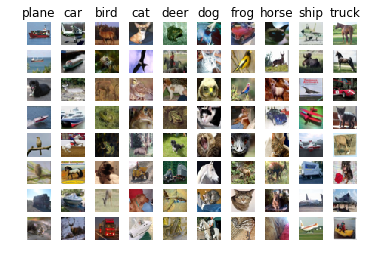

In [0]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1
Describe the misclassification results that you see. Do they make sense?

$\color{blue}{\textit Your Answer:}$ *Well, the mistakes made by the algorithm are often clear and can have an explanation: trucks are often classified as cars, deers are confused with dogs and so on. However, I've noticed several cases when SVM makes silly mistakes.*

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [0]:
print(X_train_feats.shape)

(49000, 155)


In [0]:
import numpy as np


class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.
    In other words, the network has the following architecture:
    input - fully connected layer - ReLU - fully connected layer - softmax
    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:
        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)
        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = dict()
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, x, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.
        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] < C. This parameter is optional; if it
        is not passed then we only return scores, and if it is passed then we
        instead return the loss and gradients.
        - reg: Regularization strength.
        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].
        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
        samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
        with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        w1, b1 = self.params['W1'], self.params['b1']
        w2, b2 = self.params['W2'], self.params['b2']
        n, d = x.shape

        # Compute the forward pass
        #############################################################################
        # TODO:                                                                     #
        # Perform the forward pass, computing the class scores for the input.       #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################

        a1 = x.dot(w1) + self.params['b1']            # shape N x H
        a1_relu = np.maximum(a1, np.zeros_like(a1))   # shape N x H
        scores = a1_relu.dot(w2) + self.params['b2']  # shape N x C

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        #############################################################################
        # TODO:                                                                     #
        # Finish the forward pass, and compute the loss. This should include        #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # select in each row i the score at position y[i]
        # the formula is given here http://cs231n.github.io/linear-classify/#softmax
        correct_class_scores = scores[range(x.shape[0]), y].reshape(-1, 1)
        # applying the log-sum-exp trick
        # https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/
        max_scores = scores.max(axis=1, keepdims=True)
        scores -= max_scores
        # compute softmax loss
        loss = - correct_class_scores.sum() + max_scores.sum() + np.log(np.exp(scores).sum(axis=1)).sum()
        loss /= n
        loss += reg * (np.sum(w1 * w1) + np.sum(w2 * w2))
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO:                                                                     #
        # Compute the backward pass, computing the derivatives of the weights       #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        softmax_deriv = (np.exp(scores) / np.exp(scores).sum(axis=1).reshape(-1, 1))
        softmax_deriv[range(n), y] -= 1

        # gradients of loss w.r.t. to weights W2
        # study thoroughly the linear backprop example to understand the following
        # http://cs231n.stanford.edu/handouts/linear-backprop.pdf
        dw2 = a1_relu.T.dot(softmax_deriv)
        dw2 /= n
        dw2 += 2 * reg * w2
        grads['W2'] = dw2

        # gradients of loss w.r.t. to biases b2
        db2 = np.sum(softmax_deriv, axis=0)
        db2 /= n
        grads['b2'] = db2

        # upflow gradient after ReLU
        da1_relu = softmax_deriv.dot(w2.T)

        # gradients w.r.t. activation A1 after the first layer
        da1 = da1_relu * (a1_relu > 0)

        # gradients of loss w.r.t. to weights W1
        dw1 = x.T.dot(da1)
        dw1 /= n
        dw1 += 2 * reg * w1
        grads['W1'] = dw1

        # gradients of loss w.r.t. to biases b1
        db1 = np.sum(da1, axis=0)
        db1 /= n
        grads['b1'] = db1
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        return loss, grads

    def train(self, x, y, x_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.
        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = x.shape[0]
        iterations_per_epoch = max(round(num_train / batch_size), 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            indexes = np.random.choice(x.shape[0], batch_size, replace=False)
            x_batch = x[indexes]
            y_batch = y[indexes]
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(x_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO:                                                                 #
            # Use the gradients in the grads dictionary to update the               #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            for param_name in self.params:
                self.params[param_name] -= learning_rate * grads[param_name]
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(x_batch) == y_batch).astype('int').mean()
                val_acc = (self.predict(x_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
        }

    def predict(self, x):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.
        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.
        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################
        scores = self.loss(x)
        y_pred = np.argmax(scores, axis=1)
        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################

        return y_pred

In [0]:
%%time
#from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
results = {}
best_val_acc = -1
learning_rates = np.linspace(1e-1, 1, 5)
regularization_strengths = np.linspace(1e-4, 1e-3, 3)
hidden_sizes = [300, 400, 500]

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_params = None
for lr in tqdm_notebook(learning_rates):
    for reg in tqdm_notebook(regularization_strengths):
        for hidden_size in tqdm_notebook(hidden_sizes):
            print('lr: {}, reg: {}, hidden size: {}'.format(lr, reg, hidden_size))
            net = TwoLayerNet(input_dim, hidden_size, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=1500, batch_size=200,
                    learning_rate=lr, learning_rate_decay=0.95,
                    reg=reg, verbose=False)
            y_train_pred = net.predict(X_train_feats)
            train_acc = np.mean(y_train == y_train_pred)

            val_acc = (net.predict(X_val_feats) == y_val).mean()
            print('Validation accuracy: ', val_acc)
            results[(lr, reg, hidden_size)] = val_acc
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_net = net   
                best_params = (lr, reg, hidden_size)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr: 0.1, reg: 0.0001, hidden size: 300
Validation accuracy:  0.525
lr: 0.1, reg: 0.0001, hidden size: 400
Validation accuracy:  0.522
lr: 0.1, reg: 0.0001, hidden size: 500
Validation accuracy:  0.524


lr: 0.1, reg: 0.00055, hidden size: 300
Validation accuracy:  0.527
lr: 0.1, reg: 0.00055, hidden size: 400
Validation accuracy:  0.515
lr: 0.1, reg: 0.00055, hidden size: 500
Validation accuracy:  0.525


lr: 0.1, reg: 0.001, hidden size: 300
Validation accuracy:  0.517
lr: 0.1, reg: 0.001, hidden size: 400
Validation accuracy:  0.528
lr: 0.1, reg: 0.001, hidden size: 500
Validation accuracy:  0.519


lr: 0.325, reg: 0.0001, hidden size: 300
Validation accuracy:  0.563
lr: 0.325, reg: 0.0001, hidden size: 400
Validation accuracy:  0.574
lr: 0.325, reg: 0.0001, hidden size: 500
Validation accuracy:  0.587


lr: 0.325, reg: 0.00055, hidden size: 300
Validation accuracy:  0.584
lr: 0.325, reg: 0.00055, hidden size: 400
Validation accuracy:  0.591
lr: 0.325, reg: 0.00055, hidden size: 500
Validation accuracy:  0.578


lr: 0.325, reg: 0.001, hidden size: 300
Validation accuracy:  0.579
lr: 0.325, reg: 0.001, hidden size: 400
Validation accuracy:  0.593
lr: 0.325, reg: 0.001, hidden size: 500
Validation accuracy:  0.585


lr: 0.55, reg: 0.0001, hidden size: 300
Validation accuracy:  0.588
lr: 0.55, reg: 0.0001, hidden size: 400
Validation accuracy:  0.584
lr: 0.55, reg: 0.0001, hidden size: 500
Validation accuracy:  0.581


lr: 0.55, reg: 0.00055, hidden size: 300
Validation accuracy:  0.587
lr: 0.55, reg: 0.00055, hidden size: 400
Validation accuracy:  0.591
lr: 0.55, reg: 0.00055, hidden size: 500
Validation accuracy:  0.584


lr: 0.55, reg: 0.001, hidden size: 300
Validation accuracy:  0.592
lr: 0.55, reg: 0.001, hidden size: 400
Validation accuracy:  0.568
lr: 0.55, reg: 0.001, hidden size: 500
Validation accuracy:  0.593


lr: 0.775, reg: 0.0001, hidden size: 300
Validation accuracy:  0.585
lr: 0.775, reg: 0.0001, hidden size: 400
Validation accuracy:  0.573
lr: 0.775, reg: 0.0001, hidden size: 500
Validation accuracy:  0.576


lr: 0.775, reg: 0.00055, hidden size: 300
Validation accuracy:  0.552
lr: 0.775, reg: 0.00055, hidden size: 400
Validation accuracy:  0.581
lr: 0.775, reg: 0.00055, hidden size: 500
Validation accuracy:  0.575


lr: 0.775, reg: 0.001, hidden size: 300
Validation accuracy:  0.557
lr: 0.775, reg: 0.001, hidden size: 400
Validation accuracy:  0.586
lr: 0.775, reg: 0.001, hidden size: 500
Validation accuracy:  0.561


lr: 1.0, reg: 0.0001, hidden size: 300
Validation accuracy:  0.578
lr: 1.0, reg: 0.0001, hidden size: 400
Validation accuracy:  0.563
lr: 1.0, reg: 0.0001, hidden size: 500
Validation accuracy:  0.596


lr: 1.0, reg: 0.00055, hidden size: 300
Validation accuracy:  0.578
lr: 1.0, reg: 0.00055, hidden size: 400
Validation accuracy:  0.567
lr: 1.0, reg: 0.00055, hidden size: 500
Validation accuracy:  0.575


lr: 1.0, reg: 0.001, hidden size: 300
Validation accuracy:  0.595
lr: 1.0, reg: 0.001, hidden size: 400
Validation accuracy:  0.56
lr: 1.0, reg: 0.001, hidden size: 500
Validation accuracy:  0.552

CPU times: user 13min 59s, sys: 15min 10s, total: 29min 9s
Wall time: 7min 31s


In [0]:
best_params

(0.325, 0.00055, 300)

In [0]:
best_net = TwoLayerNet(input_dim, best_params[2], num_classes)
stats = best_net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=5000, batch_size=200,
            learning_rate=best_params[0], learning_rate_decay=0.95,
            reg=best_params[1], verbose=True)

iteration 0 / 5000: loss 2.302585
iteration 100 / 5000: loss 1.684012
iteration 200 / 5000: loss 1.378974
iteration 300 / 5000: loss 1.411894
iteration 400 / 5000: loss 1.276494
iteration 500 / 5000: loss 1.229222
iteration 600 / 5000: loss 1.424251
iteration 700 / 5000: loss 1.305805
iteration 800 / 5000: loss 1.379131
iteration 900 / 5000: loss 1.218600
iteration 1000 / 5000: loss 1.214780
iteration 1100 / 5000: loss 1.103082
iteration 1200 / 5000: loss 1.338258
iteration 1300 / 5000: loss 1.134779
iteration 1400 / 5000: loss 1.047762
iteration 1500 / 5000: loss 1.092126
iteration 1600 / 5000: loss 1.082763
iteration 1700 / 5000: loss 0.989798
iteration 1800 / 5000: loss 1.148766
iteration 1900 / 5000: loss 1.208811
iteration 2000 / 5000: loss 1.144347
iteration 2100 / 5000: loss 1.049101
iteration 2200 / 5000: loss 1.193019
iteration 2300 / 5000: loss 1.035391
iteration 2400 / 5000: loss 0.984185
iteration 2500 / 5000: loss 1.124729
iteration 2600 / 5000: loss 1.038711
iteration 270

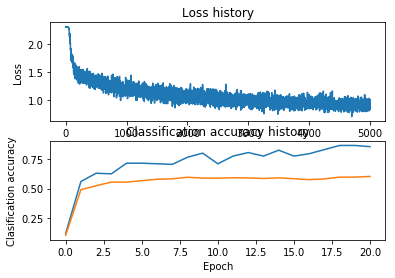

In [0]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [0]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.586
